In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.callbacks import EarlyStopping

pd.set_option('display.max_columns', None)

In [2]:
#importing data from csv file
data = pd.read_csv("good_doctor_data.csv")

#Data Cleaning and Preprocessing

In [3]:
#deleting rows with NaN values and set ID as a string type
data.dropna(how = 'all', inplace = True)
data.reset_index(drop = True, inplace = True)
data['Unique_ID'] = data['Unique_ID'].astype(int)
data['Unique_ID'] = data['Unique_ID'].astype(str)

In [4]:
#renaming data to better understanding and quicker usage
data.rename(columns = {'Unique_ID': 'ID', 'Blood Chemestry~I': 'BC I', 'Blood Chemisty~II': 'BC II', 'Blood Chemisty~III': 'BC III',
            'Skin Thickness': 'Skin Condition', 'Genetic Predisposition Factor': 'GPF', '''Air Qual'ty Index''': 'Air Quality Index', '$tate': 'State'}, inplace = True)
data

,ID,# Pregnancies,BC I,BC II,BC III,Blood Pressure,Skin Condition,BMI,GPF,Age,Air Quality Index,State,Outcome
0,5642118,1.0,0.0,23.0,10.0,74.0,20.0,27.7,0.299,21.0,38.0,CA,0.0
1,5642119,1.0,0.0,0.0,61.0,68.0,35.0,32.0,0.389,22.0,10.0,CA,0.0
2,5642120,1.0,0.0,0.0,172.0,48.0,20.0,24.7,0.140,22.0,77.0,CA,0.0
3,5642121,5.0,44.0,0.0,207.0,62.0,0.0,25.0,0.587,36.0,40.0,OR,0.0
4,5642122,2.0,56.0,45.0,150.0,56.0,28.0,24.2,0.332,22.0,70.0,CT,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3835,5642881,2.0,197.0,543.0,101.0,70.0,45.0,30.5,0.158,53.0,53.0,PA,1.0
3836,5642882,2.0,197.0,0.0,2.0,70.0,99.0,34.7,0.575,62.0,0.0,TX,1.0
3837,5642883,0.0,198.0,274.0,304.0,66.0,32.0,41.3,0.502,28.0,52.0,NJ,1.0
3838,5642884,1.0,199.0,0.0,58.0,76.0,43.0,42.9,1.394,22.0,21.0,CA,1.0


##Error identification and correction

In [5]:
#notice that we have some misspelling values such as 'KU'
data[(data['State'] == 'KU') | (data['State'] == 'KY')]

,ID,# Pregnancies,BC I,BC II,BC III,Blood Pressure,Skin Condition,BMI,GPF,Age,Air Quality Index,State,Outcome
12,5642130,2.0,68.0,66.0,49.0,70.0,32.0,25.0,0.187,25.0,0.0,KY,0.0
45,5642163,2.0,81.0,76.0,67.0,72.0,15.0,30.1,0.547,25.0,2.0,KY,0.0
101,5642219,1.0,90.0,59.0,89.0,62.0,18.0,25.1,1.268,25.0,90.0,KY,0.0
116,5642234,1.0,92.0,41.0,14.0,62.0,25.0,19.5,0.482,25.0,36.0,KY,0.0
139,5642257,1.0,95.0,38.0,53.0,66.0,13.0,19.6,0.334,25.0,52.0,KY,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3592,5642638,10.0,101.0,0.0,75.0,86.0,37.0,45.6,1.136,38.0,78.0,KU,1.0
3611,5642657,5.0,109.0,129.0,339.0,62.0,41.0,35.8,0.514,25.0,92.0,KY,1.0
3622,5642668,9.0,112.0,0.0,153.0,82.0,24.0,28.2,1.282,50.0,24.0,KY,1.0
3703,5642749,5.0,139.0,160.0,55.0,80.0,35.0,31.6,0.361,25.0,89.0,KU,1.0


In [6]:
#changing KU records to KY records
data.loc[data['State'] == 'KU', 'State'] = 'KY'

In [7]:
#here we can notice outliers in some columns
data.describe()

,# Pregnancies,BC I,BC II,BC III,Blood Pressure,Skin Condition,BMI,GPF,Age,Air Quality Index,Outcome
count,3840.000000,3815.000000,3830.000000,3840.000000,3840.000000,3835.000000,3840.000000,3840.000000,3840.000000,3810.000000,3840.000000
mean,3.845052,120.917431,79.819843,174.164583,69.105469,20.542373,31.992578,0.471876,33.513021,49.107612,0.348958
std,3.367822,32.021104,115.274861,100.894649,19.345721,15.953456,7.880052,0.331156,13.722678,29.164915,0.476703
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000,0.000000
25%,1.000000,99.000000,0.000000,86.000000,62.000000,0.000000,27.300000,0.243750,24.000000,24.000000,0.000000
50%,3.000000,117.000000,30.500000,175.000000,72.000000,23.000000,32.000000,0.372500,29.000000,49.000000,0.000000
75%,6.000000,141.000000,127.000000,259.000000,80.000000,32.000000,36.600000,0.626250,41.000000,73.000000,1.000000
max,17.000000,199.000000,846.000000,350.000000,122.000000,99.000000,67.100000,2.420000,230.000000,100.000000,1.000000


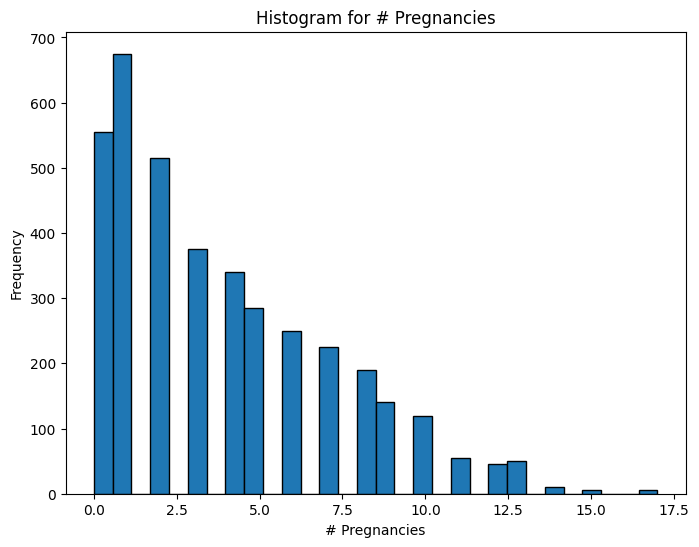

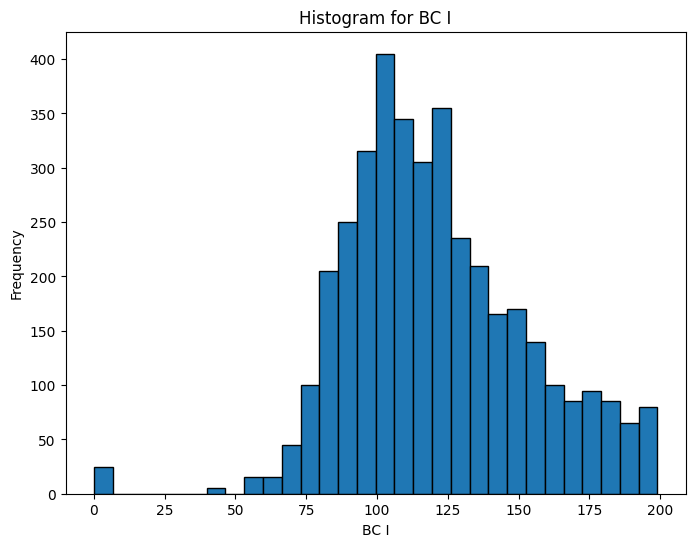

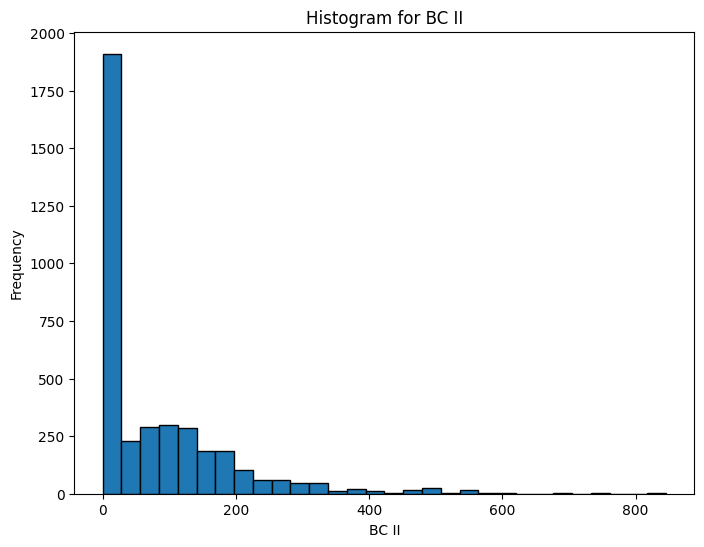

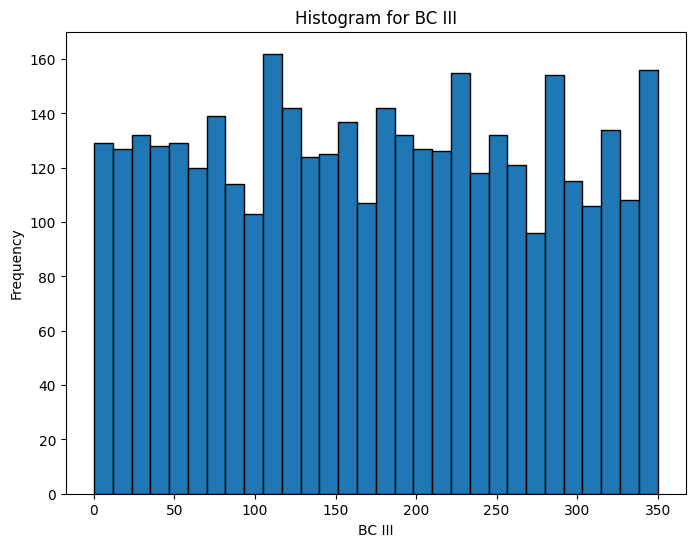

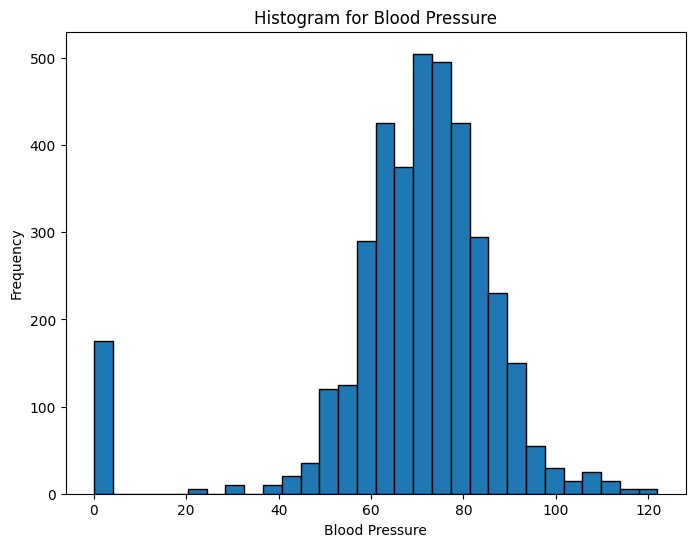

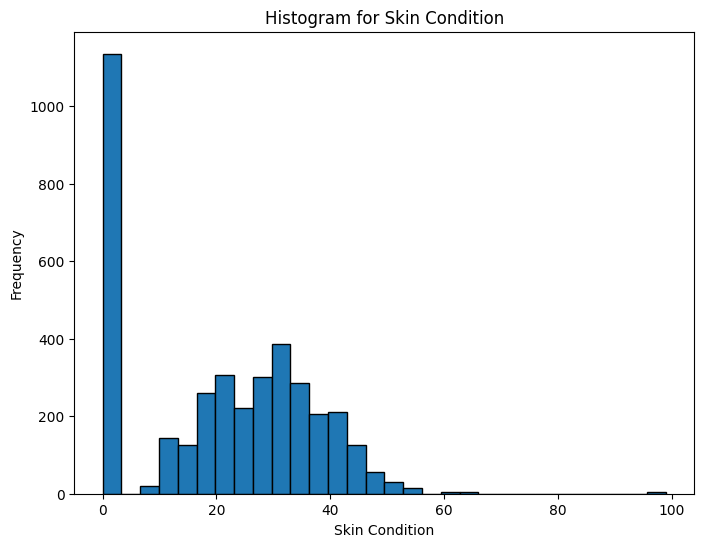

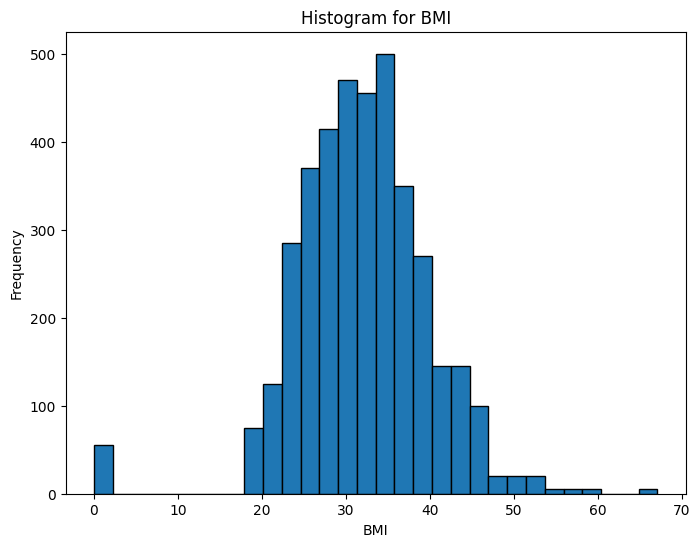

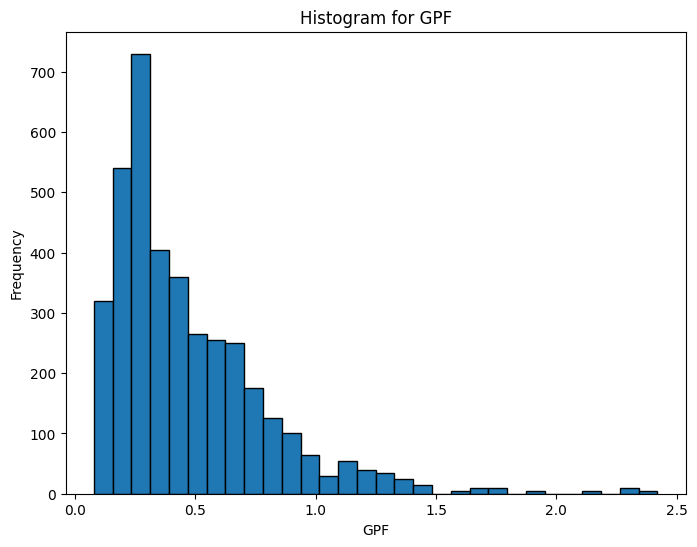

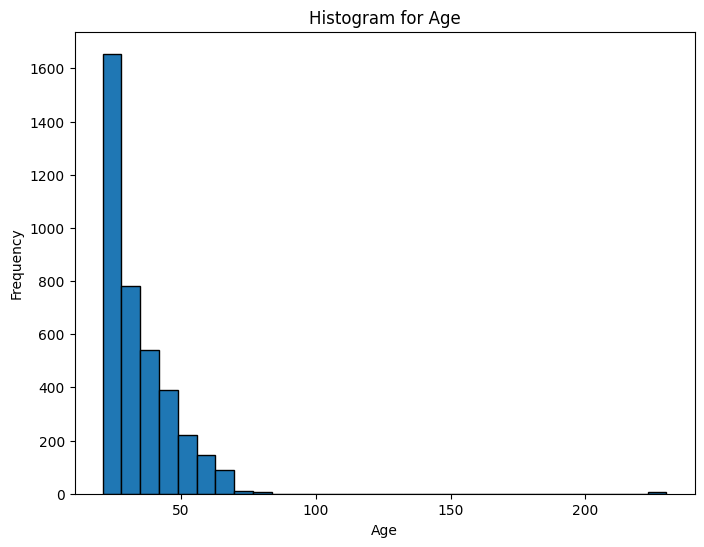

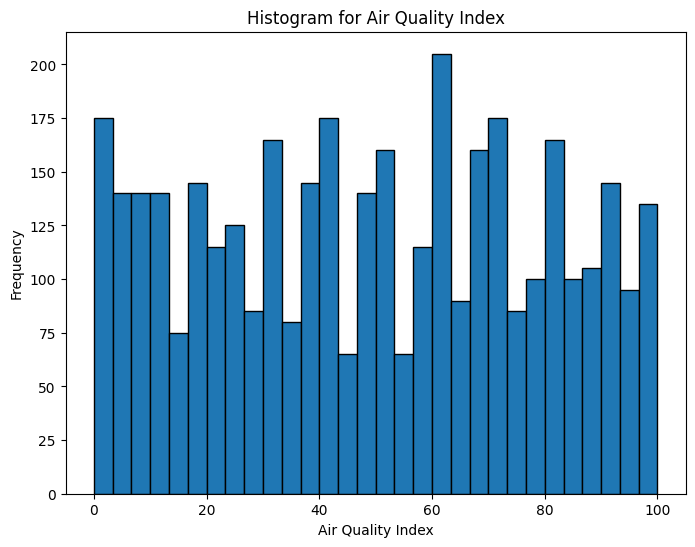

In [8]:
for column in data.columns[1:11]:
    plt.figure(figsize=(8, 6))
    plt.hist(data[column], bins=30, edgecolor='black')
    plt.title(f'Histogram for {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

In [9]:
#replacing outliers for Blood Pressure to mean depending on outcome
BP0_mean = data[data['Outcome'] == 0]['Blood Pressure'].mean()
BP1_mean = data[data['Outcome'] == 1]['Blood Pressure'].mean()

data.loc[(data['Blood Pressure'] < 30) & (data['Outcome'] == 0), 'Blood Pressure'] = BP0_mean
data.loc[(data['Blood Pressure'] < 30) & (data['Outcome'] == 1), 'Blood Pressure'] = BP1_mean

In [10]:
#replacing outliers for BMI to mean depending on outcome
BMI0_mean = data[data['Outcome'] == 0]['BMI'].mean()
BMI1_mean = data[data['Outcome'] == 1]['BMI'].mean()

data.loc[((data['BMI'] < 15) | (data['BMI'] > 55)) & (data['Outcome'] == 0), 'BMI'] = BMI0_mean
data.loc[((data['BMI'] < 15) | (data['BMI'] > 55)) & (data['Outcome'] == 1), 'BMI'] = BMI1_mean

In [11]:
#checking how many age's records are outliers
data[data['Age'] > 100]

,ID,# Pregnancies,BC I,BC II,BC III,Blood Pressure,Skin Condition,BMI,GPF,Age,Air Quality Index,State,Outcome
159,5642277,1.0,97.0,82.0,262.0,64.0,19.0,18.2,0.299,230.0,58.0,WI,0.0
927,5642277,1.0,97.0,82.0,158.0,64.0,19.0,18.2,0.299,230.0,58.0,WI,0.0
1695,5642277,1.0,97.0,82.0,55.0,64.0,19.0,18.2,0.299,230.0,58.0,WI,0.0
2463,5642277,1.0,97.0,82.0,205.0,64.0,19.0,18.2,0.299,230.0,58.0,WI,0.0
3231,5642277,1.0,97.0,82.0,307.0,64.0,19.0,18.2,0.299,230.0,58.0,WI,0.0


In [12]:
#deleting records with outlier age
data = data[data['Age'] < 100]
data.reset_index(drop = True, inplace = True)

In [13]:
#after dealing with some outliers we can check how many NaN values we have - it is better to do it after analyzing the data to avoid influence of outliers
print(data.isna().sum())

ID                    0
# Pregnancies         0
BC I                 25
BC II                10
BC III                0
Blood Pressure        0
Skin Condition        5
BMI                   0
GPF                   0
Age                   0
Air Quality Index    30
State                 0
Outcome               0
dtype: int64


In [14]:
#filling NaN values for BC I, BC II, Skin Condition and AQI with means depending on outcome value
#BC I
data.loc[data['BC I'].isna() & (data['Outcome'] == 0), 'BC I'] = data[data['Outcome'] == 0]['BC I'].mean()
data.loc[data['BC I'].isna() & (data['Outcome'] == 1), 'BC I'] = data[data['Outcome'] == 1]['BC I'].mean()

#BC II
data.loc[data['BC II'].isna() & (data['Outcome'] == 0), 'BC II'] = data[data['Outcome'] == 0]['BC II'].mean()
data.loc[data['BC II'].isna() & (data['Outcome'] == 1), 'BC II'] = data[data['Outcome'] == 1]['BC II'].mean()

#Skin Condition
data.loc[data['Skin Condition'].isna() & (data['Outcome'] == 0), 'Skin Condition'] = data[data['Outcome'] == 0]['Skin Condition'].mean()
data.loc[data['Skin Condition'].isna() & (data['Outcome'] == 1), 'Skin Condition'] = data[data['Outcome'] == 1]['Skin Condition'].mean()

#Air Quality Index
data.loc[data['Air Quality Index'].isna() & (data['Outcome'] == 0), 'Air Quality Index'] = data[data['Outcome'] == 0]['Air Quality Index'].mean()
data.loc[data['Air Quality Index'].isna() & (data['Outcome'] == 1), 'Air Quality Index'] = data[data['Outcome'] == 1]['Air Quality Index'].mean()

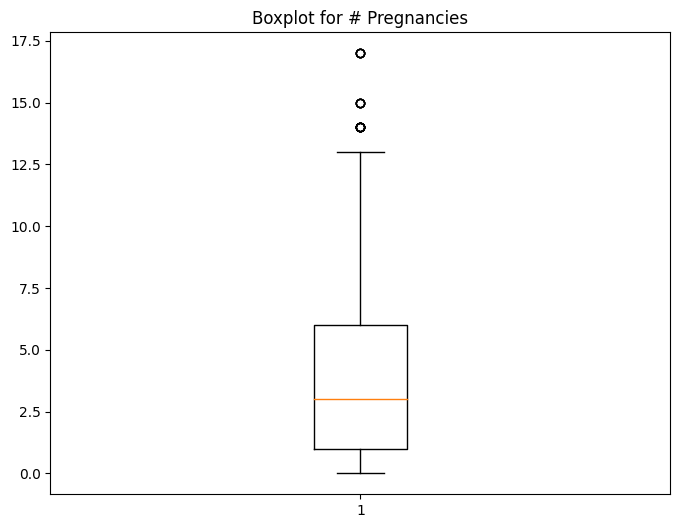

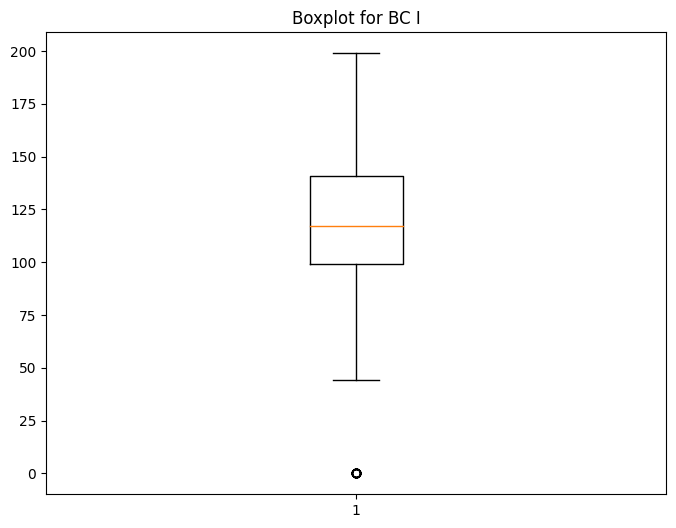

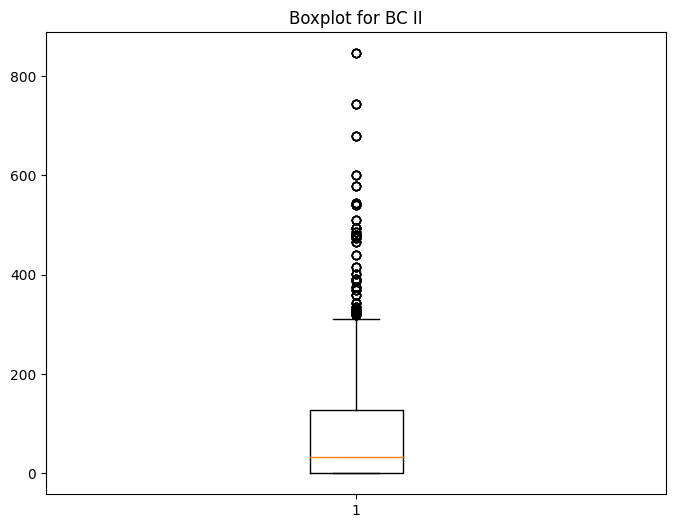

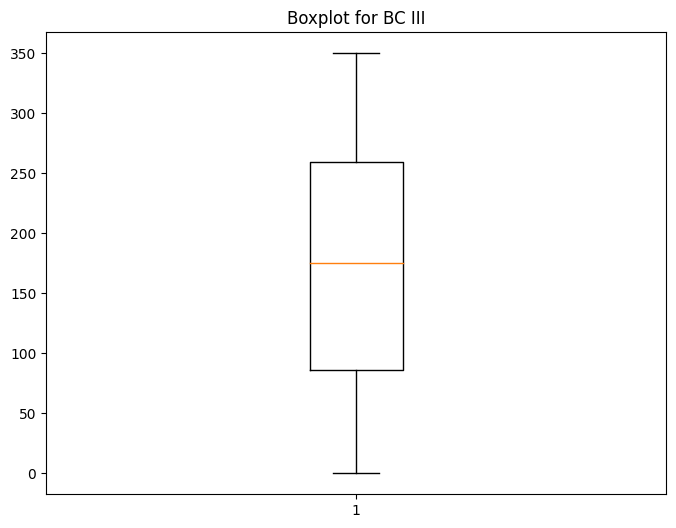

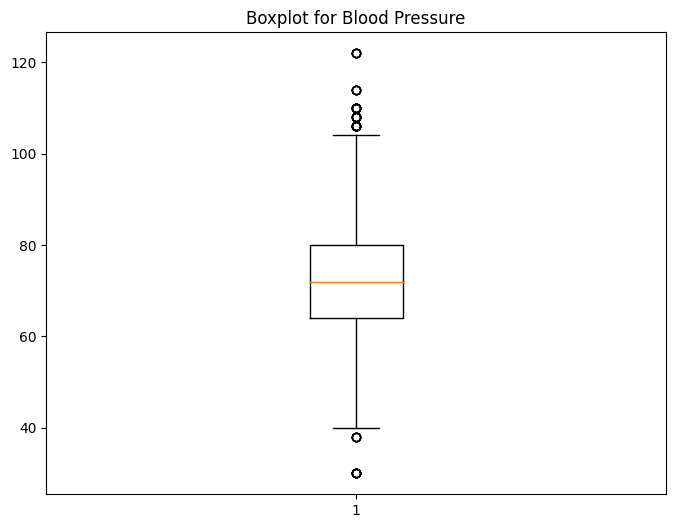

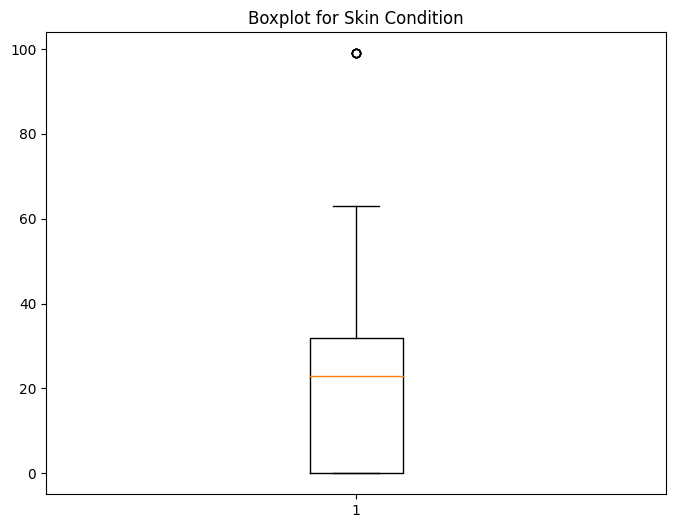

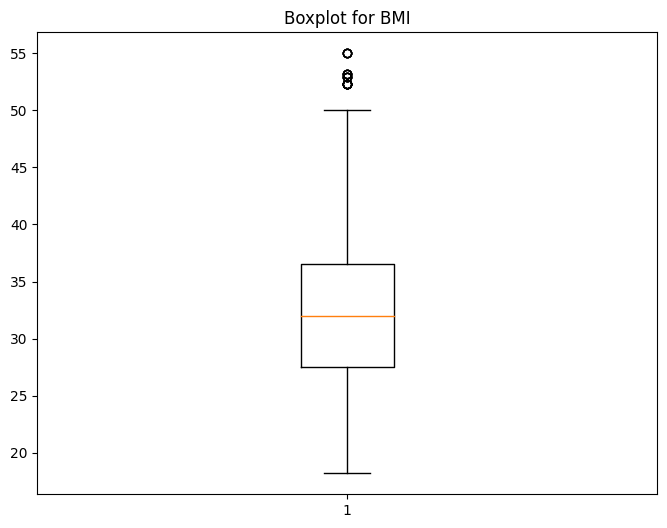

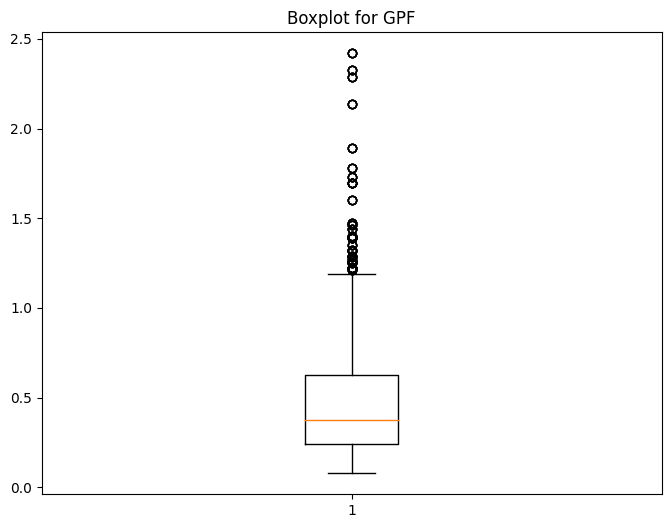

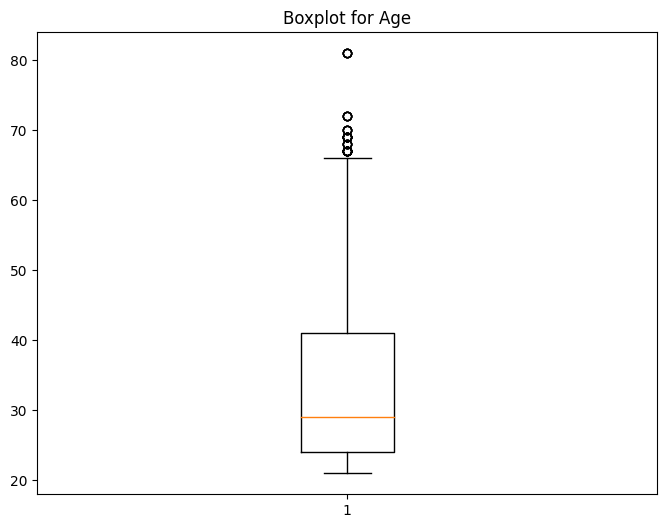

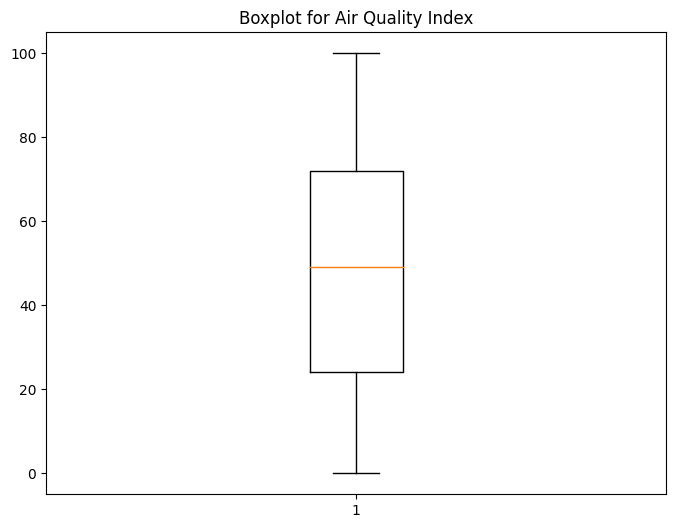

In [15]:
for column in data.columns[1:11]:
    plt.figure(figsize=(8, 6))
    plt.boxplot(data[column])
    plt.title(f'Boxplot for {column}')
    plt.show()

In [ ]:
#deleting ID column - it does not give us any value information
data = data.drop(columns = ['ID'])

In [ ]:
#we have dealt with outliers and missing values
data.describe()

,# Pregnancies,BC I,BC II,BC III,Blood Pressure,Skin Condition,BMI,GPF,Age,Air Quality Index,Outcome
count,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000
mean,3.848761,120.918150,79.829304,174.134289,72.336211,20.543250,32.349299,0.472102,33.256845,49.095519,0.349413
std,3.368449,31.944008,115.202662,100.907732,11.988499,15.953389,6.617003,0.331313,11.753444,29.068206,0.476847
min,0.000000,0.000000,0.000000,0.000000,30.000000,0.000000,18.200000,0.078000,21.000000,0.000000,0.000000
25%,1.000000,99.000000,0.000000,86.000000,64.000000,0.000000,27.500000,0.243000,24.000000,24.000000,0.000000
50%,3.000000,117.000000,32.000000,175.000000,72.000000,23.000000,32.000000,0.374000,29.000000,49.000000,0.000000
75%,6.000000,141.000000,127.000000,259.000000,80.000000,32.000000,36.500000,0.627000,41.000000,72.000000,1.000000
max,17.000000,199.000000,846.000000,350.000000,122.000000,99.000000,55.000000,2.420000,81.000000,100.000000,1.000000


<Axes: xlabel='State'>

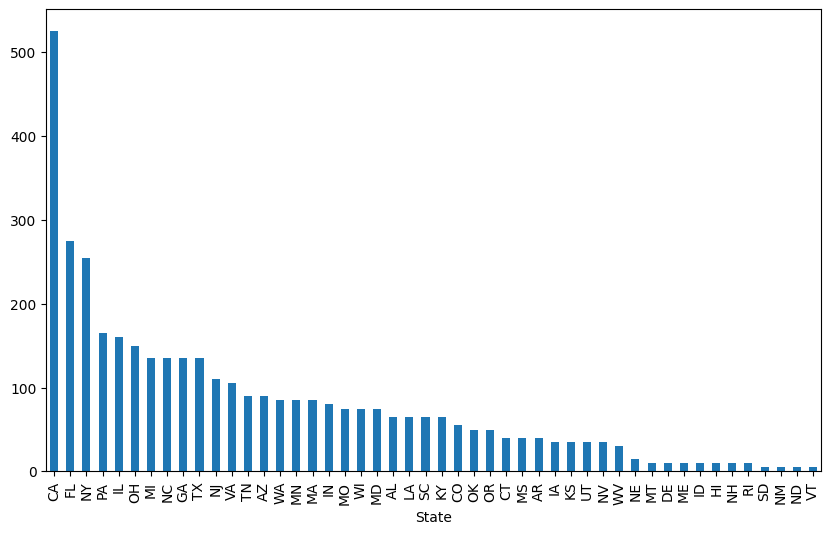

In [ ]:
plt.figure(figsize=(10, 6))
data['State'].value_counts().plot(kind='bar')

##Encoding caterogical variable and normalizing data

In [ ]:
#one-hot encoding method to convert categorical variable STATE to numerical format
data = pd.get_dummies(data, columns=['State'], drop_first=True)

In [ ]:
#normalizing the data
scaler = MinMaxScaler()
norm_data = scaler.fit_transform(data)
data_scaled = pd.DataFrame(norm_data, columns=data.columns)

#Exploratory Data Analysis

In [ ]:
#here we can see dispersion of all variables in one scale - it gives us more information about variables between each other
data_scaled.describe()

,# Pregnancies,BC I,BC II,BC III,Blood Pressure,Skin Condition,BMI,GPF,Age,Air Quality Index,Outcome,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DE,State_FL,State_GA,State_HI,State_IA,State_ID,State_IL,State_IN,State_KS,State_KY,State_LA,State_MA,State_MD,State_ME,State_MI,State_MN,State_MO,State_MS,State_MT,State_NC,State_ND,State_NE,State_NH,State_NJ,State_NM,State_NV,State_NY,State_OH,State_OK,State_OR,State_PA,State_RI,State_SC,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV
count,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000
mean,0.226398,0.607629,0.094361,0.497527,0.460176,0.207508,0.384492,0.168276,0.204281,0.490955,0.349413,0.010430,0.023468,0.136897,0.014342,0.010430,0.002608,0.071708,0.035202,0.002608,0.009126,0.002608,0.041721,0.020860,0.009126,0.016949,0.016949,0.022164,0.019557,0.002608,0.035202,0.022164,0.019557,0.010430,0.002608,0.035202,0.001304,0.003911,0.002608,0.028683,0.001304,0.009126,0.066493,0.039113,0.013038,0.013038,0.043025,0.002608,0.016949,0.001304,0.023468,0.035202,0.009126,0.027379,0.001304,0.022164,0.019557,0.007823
std,0.198144,0.160523,0.136173,0.288308,0.130310,0.161145,0.179810,0.141466,0.195891,0.290682,0.476847,0.101608,0.151404,0.343783,0.118910,0.101608,0.051004,0.258037,0.184314,0.051004,0.095108,0.051004,0.199977,0.142936,0.095108,0.129098,0.129098,0.147237,0.138489,0.051004,0.184314,0.147237,0.138489,0.101608,0.051004,0.184314,0.036089,0.062426,0.051004,0.166936,0.036089,0.095108,0.249174,0.193890,0.113451,0.113451,0.202939,0.051004,0.129098,0.036089,0.151404,0.184314,0.095108,0.163208,0.036089,0.147237,0.138489,0.088111
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.058824,0.497487,0.000000,0.245714,0.369565,0.000000,0.252717,0.070453,0.050000,0.240000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.176471,0.587940,0.037825,0.500000,0.456522,0.232323,0.375000,0.126388,0.133333,0.490000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.352941,0.708543,0.150118,0.740000,0.543478,0.323232,0.497283,0.234415,0.333333,0.720000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00

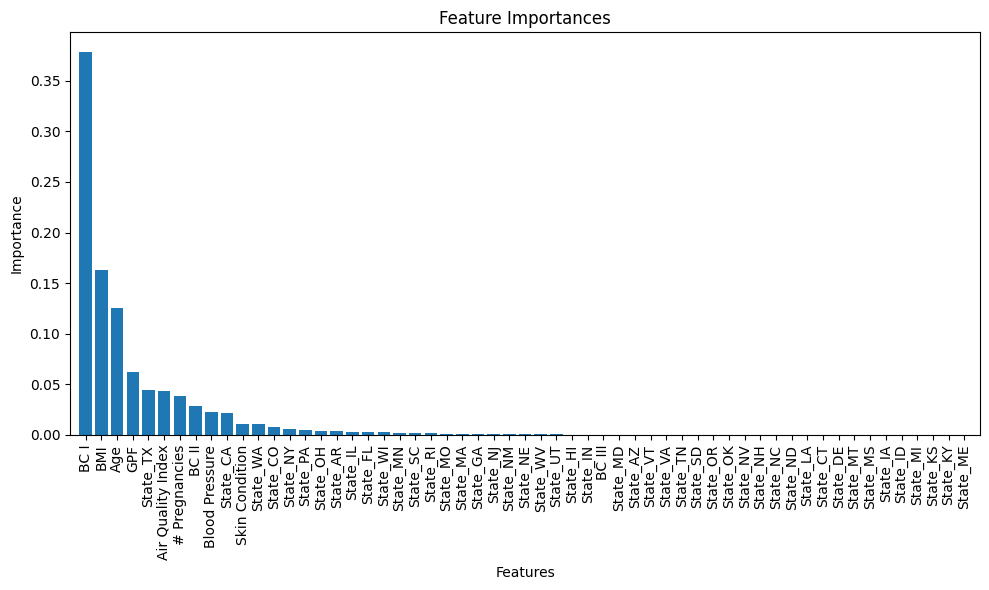

In [ ]:
#our dataset consist 57 explanatory variables so we apply feature selection to select most influence variables
X_data = data_scaled.drop(columns= ['Outcome'])

clf = GradientBoostingClassifier()
clf.fit(X_data, data_scaled['Outcome'])
importances = clf.feature_importances_ # to get feature importances
indices = np.argsort(importances)[::-1] # sort in descending order

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_data.shape[1]), importances[indices], align="center")
plt.xticks(range(X_data.shape[1]), X_data.columns[indices], rotation=90)
plt.xlim([-1, X_data.shape[1]])
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

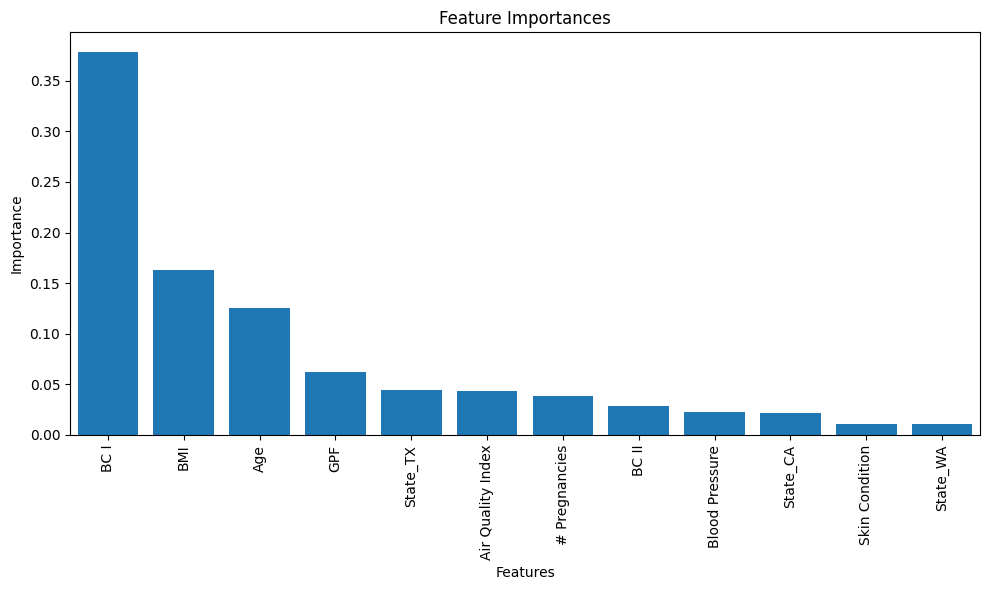

In [ ]:
# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_data.shape[1]), importances[indices], align="center")
plt.xticks(range(X_data.shape[1]), X_data.columns[indices], rotation=90)
plt.xlim([-0.5, 11.5])
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

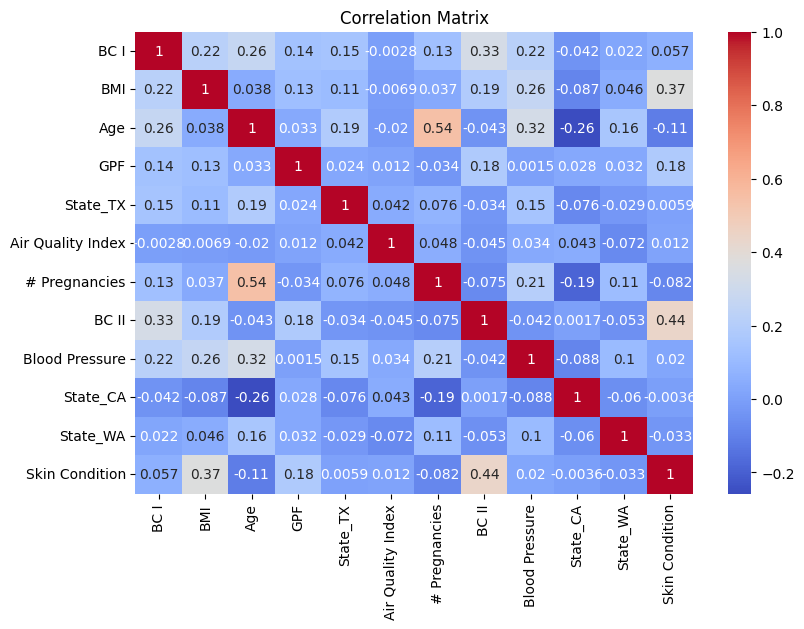

In [ ]:
corr_matrix = data_scaled[['BC I', 'BMI', 'Age', 'GPF', 'State_TX', 'Air Quality Index', '# Pregnancies', 'BC II', 'Blood Pressure', 'State_CA', 'State_WA', 'Skin Condition']].corr()
plt.figure(figsize=(9, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
print("Average age in CA:", data[data['State_CA'] == 1]['Age'].mean())
print("Average age in other states:", data[data['State_CA'] == 0]['Age'].mean())

print("Average age in TX :", data[data['State_TX'] == 1]['Age'].mean())
print("Average age in other states:", data[data['State_TX'] == 0]['Age'].mean())

print("Number of records from TX:", data[data['State_TX'] == 1].shape[0])
print("Number of records from TX with disease:", data[data['State_TX'] == 1]['Outcome'].sum())

Average age in CA: 25.666666666666668
Average age in other states: 34.4607250755287
Average age in TX : 44.81481481481482
Average age in other states: 32.83513513513513
Number of records from TX: 135
Number of records from TX with disease: 130.0


#Predictive Modeling and Evaluation

##Logistic Regression


###with imbalanced data

In [ ]:
#Logistic regression
X_data = data_scaled[['BC I', 'BMI', 'Age', 'GPF', 'State_TX', 'Air Quality Index', '# Pregnancies', 'BC II', 'Blood Pressure', 'State_CA', 'State_WA', 'Skin Condition']]
X_train, X_test, y_train, y_test = train_test_split(X_data, data_scaled['Outcome'], test_size=0.2, random_state=10)

model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
y_pred_prob_lr = model_lr.predict_proba(X_test)[:, 1]

<Figure size 600x600 with 0 Axes>

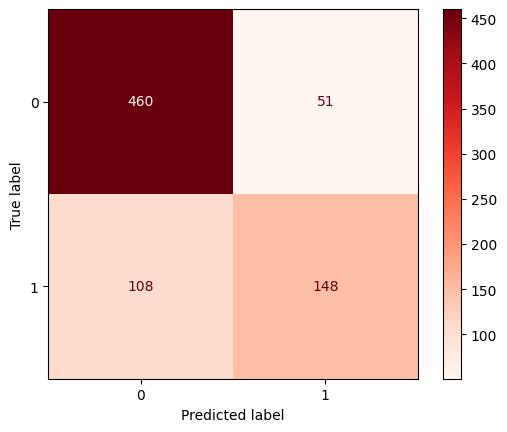

In [ ]:
# Confusion matrix
plt.figure(figsize=(6, 6))
cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Reds)
plt.show()

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred_lr)) # (TP + TN) / (TP + FP + FN + TN)
print("Precision:", precision_score(y_test, y_pred_lr)) # TP / (TP + FP)
print("Recall:", recall_score(y_test, y_pred_lr)) # TP / (TP + FN)
print("F1 score:", f1_score(y_test, y_pred_lr)) # 2 * (precision * recall) / (precision + recall)

Accuracy: 0.7926988265971316
Precision: 0.7437185929648241
Recall: 0.578125
F1 score: 0.6505494505494506


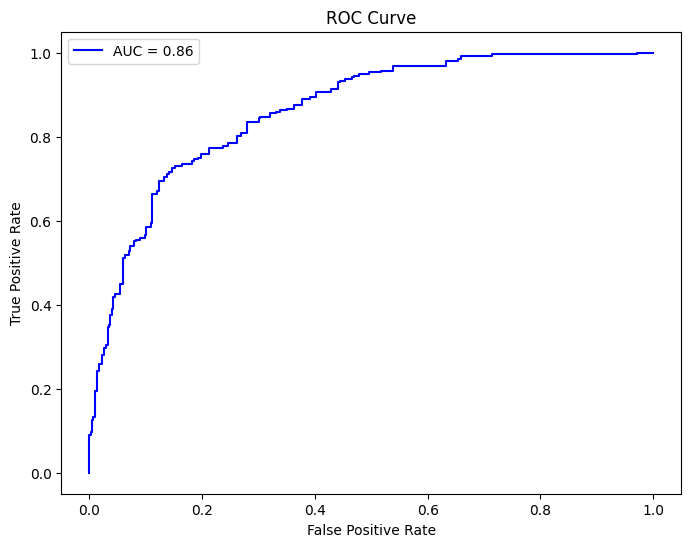

In [ ]:
# ROC curve
# TPR = TP / (TP + FN)
# FPR = FP / (FP + TN)

fpr, tpr, _ = roc_curve(y_test, y_pred_prob_lr)
roc_auc = roc_auc_score(y_test, y_pred_prob_lr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

###with balanced data

In [ ]:
#we can look how many records we have in '0' and '1' class
data['Outcome'].value_counts()

,count
Outcome,
0.0,2495
1.0,1340


In [ ]:
#in that case we calculate imbalance coefficient - it will be useful for assigning weights
imbalance_coefficient = round(data['Outcome'].value_counts()[1] / data['Outcome'].value_counts()[0], 2)

In [ ]:
#Logistic regression with weights
model_blr = LogisticRegression(class_weight = {0: imbalance_coefficient, 1: 1})
model_blr.fit(X_train, y_train)
y_pred_blr = model_blr.predict(X_test)
y_pred_prob_blr = model_blr.predict_proba(X_test)[:, 1]

<Figure size 600x600 with 0 Axes>

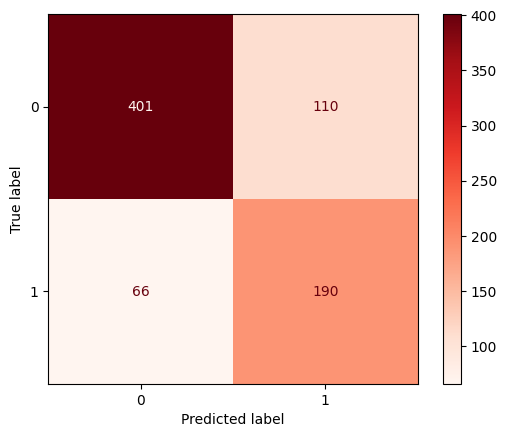

In [ ]:
# Confusion matrix
plt.figure(figsize=(6, 6))
cm = confusion_matrix(y_test, y_pred_blr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Reds)
plt.show()

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred_blr))
print("Precision:", precision_score(y_test, y_pred_blr))
print("Recall:", recall_score(y_test, y_pred_blr))
print("F1 score:", f1_score(y_test, y_pred_blr))

Accuracy: 0.7705345501955672
Precision: 0.6333333333333333
Recall: 0.7421875
F1 score: 0.6834532374100719


<ipython-input-41-1268358a5879>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1],'r--', color = 'grey')


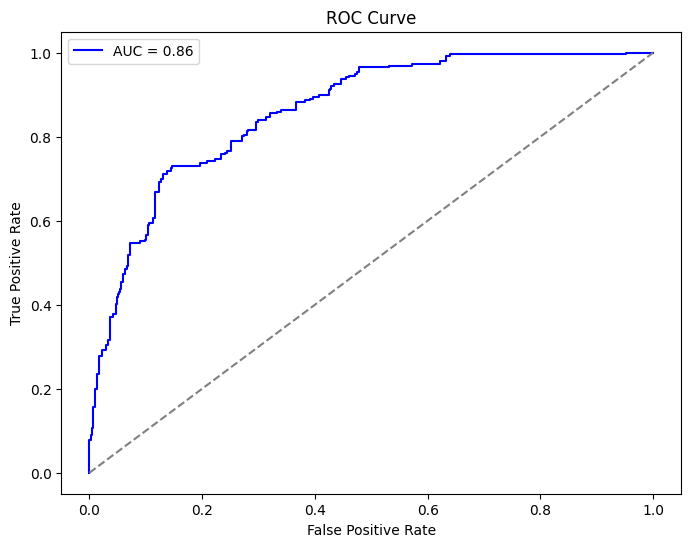

In [ ]:
# ROC curve
# TPR = TP / (TP + FN)
# FPR = FP / (FP + TN)

fpr, tpr, _ = roc_curve(y_test, y_pred_prob_blr)
roc_auc = roc_auc_score(y_test, y_pred_prob_blr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1],'r--', color = 'grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

##Neural network

In [ ]:
#Neural network with binary classification
smote = SMOTE(sampling_strategy= 0.7 ,random_state=18)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

NN_model = Sequential([
    Dense(12, activation='relu', input_shape=(X_train.shape[1],)), #input layer
    Dense(6, activation='relu'), #hidden
    Dense(1, activation='sigmoid')  # output, sigmoid function to predict binary classification
])
NN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
NN_model.fit(X_train_res, y_train_res, epochs=40, batch_size=16, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5263 - loss: 0.6795 - val_accuracy: 0.4074 - val_loss: 0.7535
Epoch 2/40
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6974 - loss: 0.5973 - val_accuracy: 0.4815 - val_loss: 0.6990
Epoch 3/40
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6966 - loss: 0.5728 - val_accuracy: 0.4711 - val_loss: 0.7394
Epoch 4/40
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7278 - loss: 0.5292 - val_accuracy: 0.5689 - val_loss: 0.6629
Epoch 5/40
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7429 - loss: 0.5067 - val_accuracy: 0.6119 - val_loss: 0.6252
Epoch 6/40
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7568 - loss: 0.4913 - val_accuracy: 0.6489 - val_loss: 0.5897
Epoch 7/40
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7637 - loss: 0.4704 - val_accuracy: 0.6148 - val_loss: 0.6447
Epoch 8/40
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7662 - loss: 0.4597 - val_accuracy: 0.6296 - val_

In [ ]:
y_pred_proba = NN_model.predict(X_test)
y_pred_NN = (y_pred_proba >= 0.5).astype(int)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


<Figure size 600x600 with 0 Axes>

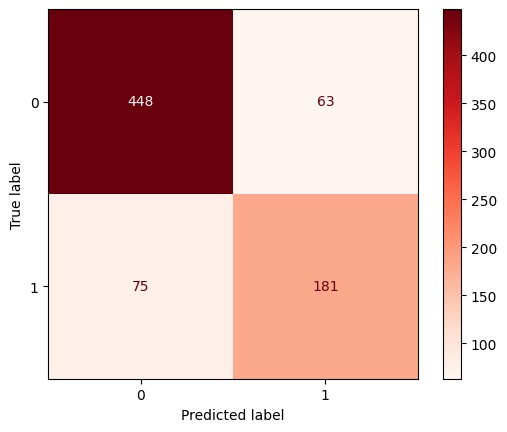

In [ ]:
# Confusion matrix
plt.figure(figsize=(6, 6))
cm = confusion_matrix(y_test, y_pred_NN)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Reds)
plt.show()

In [ ]:
#accuracy, precision, recall and f1-score for neural networks
print("Accuracy:", accuracy_score(y_test, y_pred_NN))
print("Precision:", precision_score(y_test, y_pred_NN))
print("Recall:", recall_score(y_test, y_pred_NN))
print("F1 score:", f1_score(y_test, y_pred_NN))

Accuracy: 0.8200782268578879
Precision: 0.7418032786885246
Recall: 0.70703125
F1 score: 0.724


<ipython-input-82-62aaa9c13141>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1],'r--', color = 'grey')


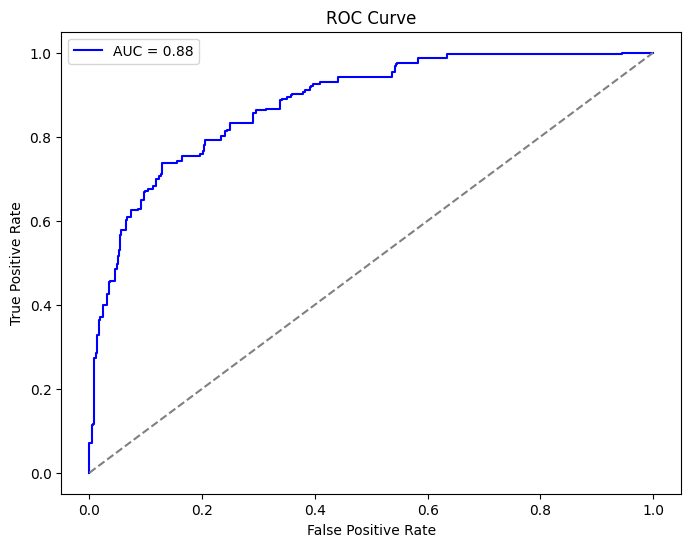

In [ ]:
#ROC Curve for neural networks
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1],'r--', color = 'grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()